In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from matplotlib_venn import venn2_unweighted, venn3_unweighted

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)

# Example real data analysis

In [2]:
# Folders
gwas_dir = './real/gwas30_noMHC'
anno_dir = './real/data'
out_dir = './real/example'
trait = 'Bipolar_Disorder'
anno = 'region9tissue127'

## Copy and paste the commands to run in terminal (under \<installation path\>)

### PALM-Tree (tree depth J = 1 or 2)

In [3]:
# Settings
J = 1
v = 0.1
gam = 0
lam = 0
K = 2
max_iter = 3000
print_every = 1000

# PALM-Tree command
command = f'python ./PALM/prioritize.py \
    --out {out_dir}/{trait}-J{J}-v{v} \
    --sumstats {gwas_dir}/{trait}.csv \
    --annotation {anno_dir}/{anno}.csv \
    --model tree --depth {J} --eta {v} --gam {gam} --lam {lam} \
    --max-iter {max_iter} --print-freq {print_every} --nfold {K} -v'
print(command)

python ./PALM/prioritize.py     --out ./real/example/Bipolar_Disorder-J1-v0.1     --sumstats ./real/gwas30_noMHC/Bipolar_Disorder.csv     --annotation ./real/data/region9tissue127.csv     --model tree --depth 1 --eta 0.1 --gam 0 --lam 0     --max-iter 3000 --print-freq 1000 --nfold 2 -v


### Two-groups model

In [4]:
# Two-groups model command
command = f'python ./PALM/tgm.py \
    --out {out_dir}/{trait} \
    --sumstats {gwas_dir}/{trait}.csv \
    --max-iter 1000 --print-freq 100 -v'
print(command)

python ./PALM/tgm.py     --out ./real/example/Bipolar_Disorder     --sumstats ./real/gwas30_noMHC/Bipolar_Disorder.csv     --max-iter 1000 --print-freq 100 -v


## Results

In [5]:
# Prioritization result
out_dir = '../real/example'
ret_tree1 = pd.read_csv(f'{out_dir}/{trait}-J1-v{v}-PALM-tree-prioritize.csv', sep='\t')
ret_tree2 = pd.read_csv(f'{out_dir}/{trait}-J2-v{v}-PALM-tree-prioritize.csv', sep='\t')
ret_tgm = pd.read_csv(f'{out_dir}/{trait}-TGM-prioritize.csv', sep='\t')

In [6]:
# Compare number of prioritized risk SNPs 
default_colors = [
    # r, g, b, a
    [92, 192, 98, 0.5],
    [90, 155, 212, 0.5],
    [246, 236, 86, 0.6],
    [241, 90, 96, 0.4],
    [255, 117, 0, 0.3],
    [82, 82, 190, 0.2],
]
default_colors = [
    [i[0] / 255.0, i[1] / 255.0, i[2] / 255.0, i[3]]
    for i in default_colors
]
    
def Venn3Plot(dfA,dfB,dfC,labels,title):
    A = set(dfA.loc[dfA.assoc == 1, 'SNP'])
    B = set(dfB.loc[dfB.assoc == 1, 'SNP'])
    C = set(dfC.loc[dfC.assoc == 1, 'SNP'])
    AB_overlap = A & B  #compute intersection of set A & set B
    AC_overlap = A & C
    BC_overlap = B & C
    ABC_overlap = A & B & C
    A_rest = A - AB_overlap - AC_overlap #see left graphic
    B_rest = B - AB_overlap - BC_overlap
    C_rest = C - AC_overlap - BC_overlap
    AB_only = AB_overlap - ABC_overlap   #see right graphic
    AC_only = AC_overlap - ABC_overlap
    BC_only = BC_overlap - ABC_overlap

    sets = Counter()         
    sets['100'] = len(A_rest)
    sets['010'] = len(B_rest)
    sets['001'] = len(C_rest)
    sets['110'] = len(AB_only)
    sets['101'] = len(AC_only)
    sets['011'] = len(BC_only)
    sets['111'] = len(ABC_overlap)
    # sns.set_context('paper',font_scale=1.2)
    plt.figure(figsize=(4,4),dpi=150) 
    ax = plt.gca() 
    venn3_unweighted(subsets=sets, set_labels=labels, ax=ax, set_colors=default_colors[1:])
    plt.title(title, fontsize=12)
    plt.show()


### Comparison in number of identified risk SNPs

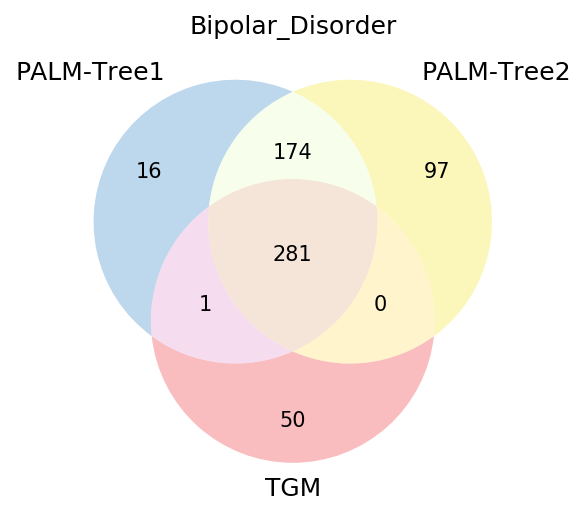

In [7]:
Venn3Plot(ret_tree1, ret_tree2, ret_tgm, [f'PALM-Tree1', f'PALM-Tree2', 'TGM'], trait)

### CV deviance on test data of each fold (PALM-Tree2)

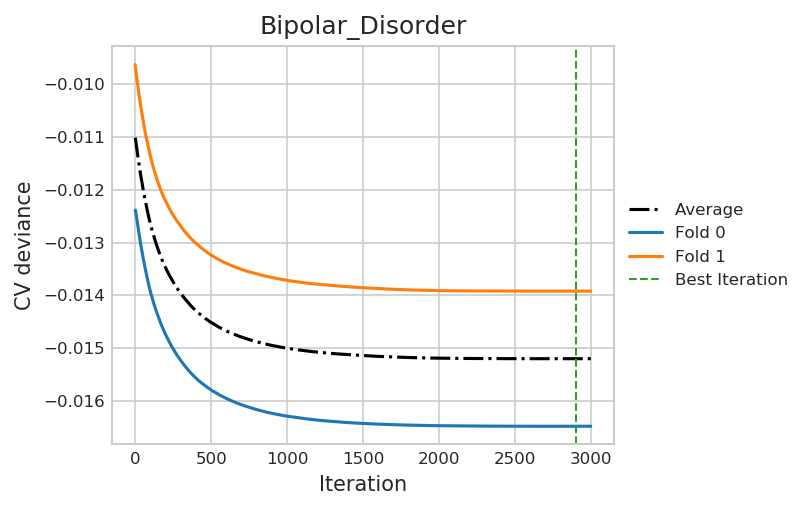

In [8]:
# CV scores
J = 2
cv_df = pd.read_csv(f'{out_dir}/{trait}-J{J}-v{v}-PALM-tree-cv.csv', sep='\t')
avg_Lq = np.mean(cv_df.values, axis=1)
opt_iter = np.argmax(avg_Lq[1:]) + 1
# Plot CV deviance against iteration
plt.style.use('seaborn-whitegrid')
colors = plt.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(5.5, 3.5), dpi=150)
ax.plot(np.arange(len(avg_Lq) - 1), -2 * avg_Lq[1:], ls='dashdot', linewidth=1.5, color='black', label=f'Average')
for k in range(K):
    ax.plot(np.arange(len(avg_Lq) - 1), -2 * cv_df.iloc[1:, k], ls='-', linewidth=1.5, c=colors(k), label=f'Fold {k}')
ax.axvline(opt_iter, color=colors(k+1), linestyle='--', linewidth=1, label='Best Iteration')
ax.legend(loc='center left', prop={'size': 8}, bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Iteration')
ax.set_ylabel('CV deviance')
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_title(trait)
plt.tight_layout()
plt.show()

### Variable importance evaluation (PALM-Tree2)

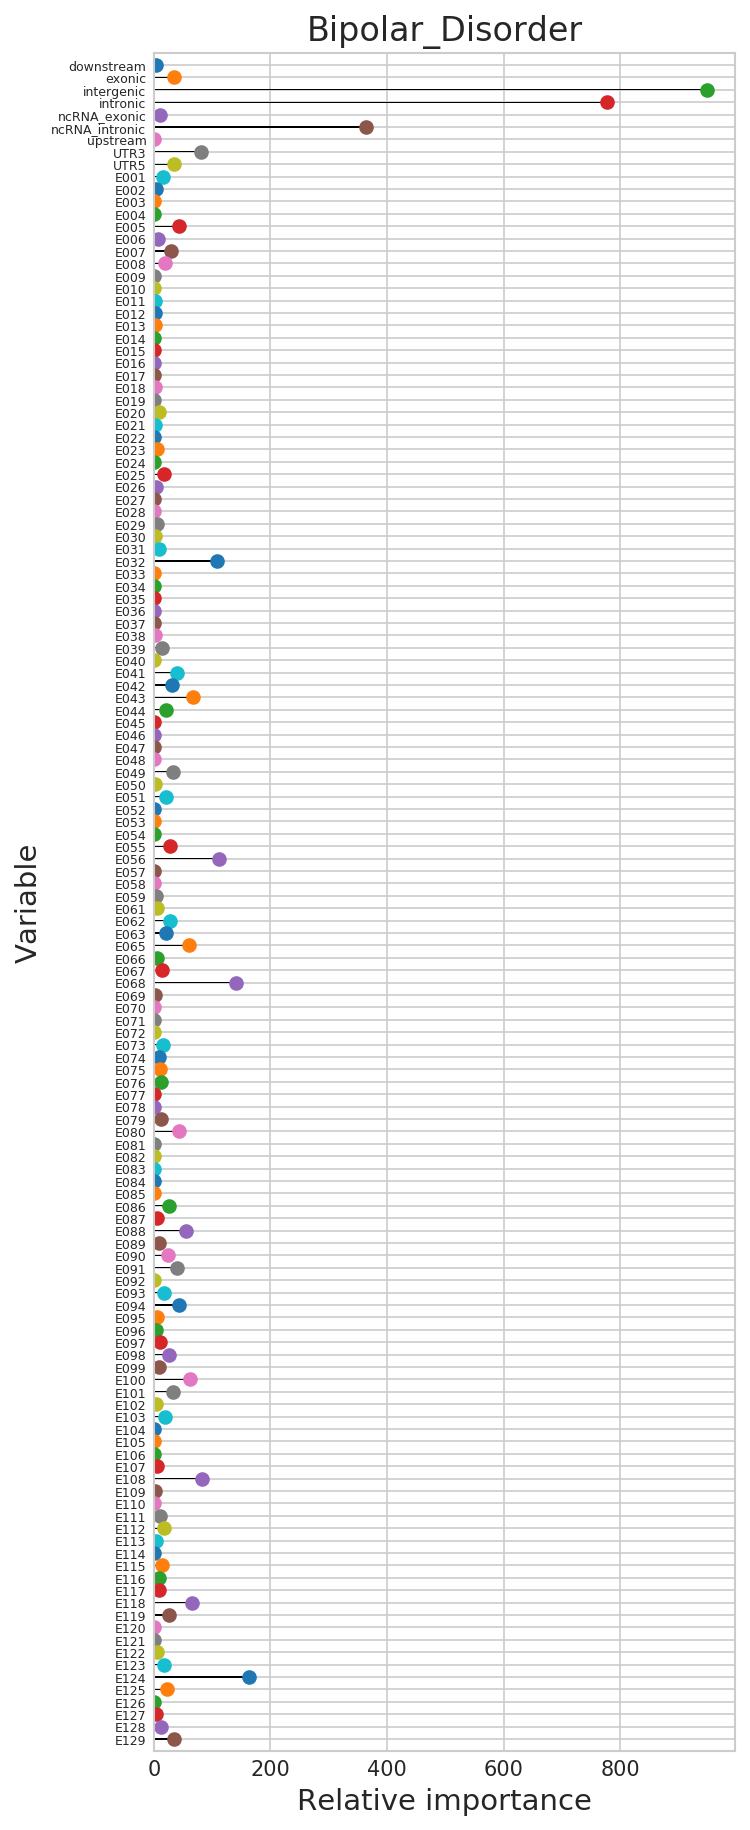

In [9]:
# Variable importance
J = 2
imp_df = pd.read_csv(f'{out_dir}/{trait}-J{J}-v{v}-PALM-tree-importance.csv', sep='\t')
var_imp = imp_df.importance
D = len(var_imp)
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(5, 15), dpi=150)
ax.set_prop_cycle('color', plt.cm.tab10.colors)
for i in range(len(var_imp)):
    ax.plot(var_imp[i], i, 'o', ms=6)
ax.barh(np.arange(len(var_imp)), var_imp, align='center', color='black', height=0.1)
ax.tick_params(axis='y', which='major', labelsize=6)
ax.tick_params(axis='y', which='minor', labelsize=6)
ax.set_yticks(np.arange(len(var_imp)))
ax.set_yticklabels(imp_df.annot)
ax.set_ylim(-1, D)
ax.invert_yaxis()
ax.set_xlabel('Relative importance', fontsize=14)
ax.set_ylabel('Variable', fontsize=14)
ax.set_title(trait, fontsize=16)
plt.show()